# Chaines de Markov 
#### Propagation d'une épidémie dans une population

In [29]:
# Importer les librairies nécessaires
import numpy as np
import random as rd 
import matplotlib.pyplot as plt

# Configuration des graphes
import matplotlib as mpl
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="hls", font="sans-serif", font_scale=1.4) 
from matplotlib import pyplot, transforms
mpl.rcParams['figure.figsize'] = (15, 10)

Considérons des populations constituées de 3 types d'individus. Chaque individu est dans un des 3 états : sain $S$, infecté $I$ ou guéri $R$. 

Considérons qu'à chaque temps : 
- chaque individu sain peut rester sain ou devenir infecté;
- chaque individu infecté peut rester infecté ou devenir guéri;
- chaque individu guéri reste guéri *(hypothèse pour le premier exo)*

L'information utile pour la prédiction du futur est entièrement contenue dans l'état présent du processus *(propriété de Markov)*.

## 1 - Description du premier modèle

Au temps $t=0$, un individu a une probabilité de $0.9$ d'être sain et $0.1$ d'être infecté.

Un individu dans l'état sain a une probabilité de $0.92$ de rester sain et une probabilité de $0.08$ de devenir infecté. 

Si l'individu est infecté, il peut le rester avec une probabilité de $0.93$ et être guéri avec une probabilité de $0.07$. 

S'il est dans l'état guéri, il reste dans ces état avec une probabilité de $1$. 

![](graph.png)

À partir de l'hypothèse supposé au début de l'énoncé, il y a donc trois états, soient sain $S$, infecté $I$ et guéri $R$. Le vecteur de probabilité initiale est de taille $3$ et la matrice de transition est de taille $3\times3$.

On a strictement besoin que : 

$$\pi_0=\{0.9,\, 0.1,\, 0\}$$

$$A = \begin{bmatrix} 0.92 & 0.08 & 0 \\ 0 & 0.93 & 0.07 \\ 0 & 0 & 1 \end{bmatrix}$$

In [42]:
# Fonction pour vérifier qu'une matrice est stochastique et vérifier que A est stochastique
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
def is_stochastic(Matrix) : 
  """
  Déterminer si la matrice prise en entrée est stochastique.

  Paramètres
  ---------
    A : matrice à déterminer
  """
  verif = [np.sum(i)==1 for i in Matrix]
  return np.sum(verif)==len(Matrix)

# Test si A est stochastic
# Le résultat de ce test doit forcément rretourner True
if is_stochastic(A) : print("A est stochastique")
else : print("A n'est pas stochastique")

A est stochastique


### 1.1 Distribution théorique
Notons $\pi_t$, le vecteur de probabilité au temps $t$.

On sait que : $\mathbb{P}(C_{0}=S) = 0.9$, $\mathbb{P}(C_{0}=I) = 0.1$, $\mathbb{P}(C_{0}=R) = 0$ et que $\pi

---

Au temps $t=1$, on a : 

$\mathbb{P}(C_{1}=S) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{1}=S, C_0=i) = \mathbb{P}(C_{0}=S|C_0=i)\mathbb{P}(C_0=i) = 0.92*0.9 = 0.828$

$\mathbb{P}(C_{1}=I) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{1}=I, C_0=i) = \mathbb{P}(C_{0}=I|C_0=i)\mathbb{P}(C_0=i) = 0.08*0.9 + 0.93*0.1 = 0.165$

$\mathbb{P}(C_{1}=R) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{1}=R, C_0=i) = \mathbb{P}(C_{0}=R|C_0=i)\mathbb{P}(C_0=i) = 0.07 * 0.1 = 0.007$

On obtient $\pi_1 = \{0.828,\, 0.165,\, 0.007\}$

---

Au temps $t=2$, on a : 

$\mathbb{P}(C_{2}=S) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{2}=S, C_1=i) = \mathbb{P}(C_{1}=S|C_1=i)\mathbb{P}(C_1=i) = 0.92*0.828 = 0.76176$

$\mathbb{P}(C_{2}=I) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{2}=I, C_1=i) = \mathbb{P}(C_{1}=I|C_1=i)\mathbb{P}(C_1=i) = 0.08*0.828 + 0.93*0.165 = 0.21969$

$\mathbb{P}(C_{2}=R) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{2}=R, C_1=i) = \mathbb{P}(C_{1}=R|C_1=i)\mathbb{P}(C_1=i) = 0.07 * 0.165 + 0.007*1 = 0.01855$

On obtient $\pi_1 = \{0.76176,\, 0.21969,\, 0.01855\}$

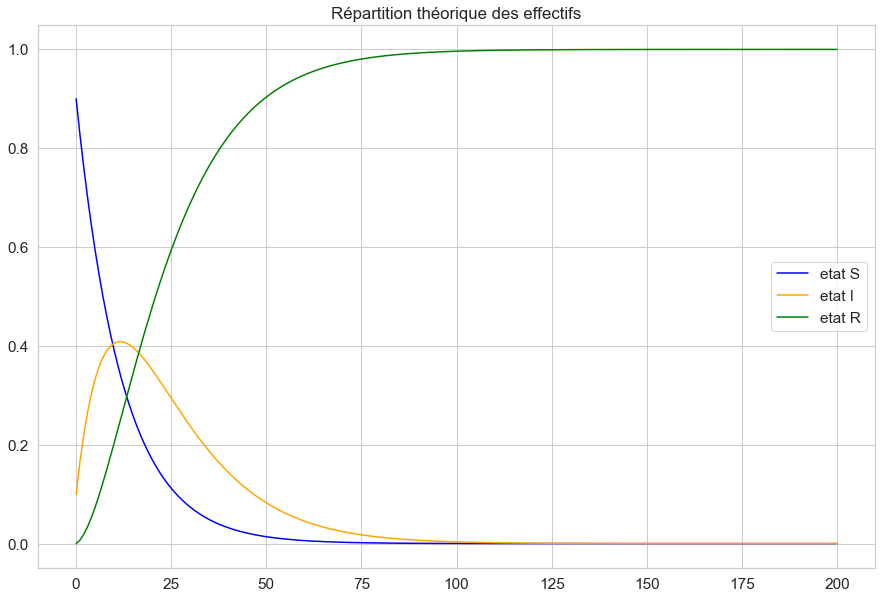

In [31]:
# Calcul de la distrubution théorique, t entre 1 et 200
pi_0 = [0.9, 0.1, 0]
S, I, R = [pi_0[0]], [pi_0[1]], [pi_0[2]]
for i in range(1,201) :
  pi_0 = np.dot(pi_0, A)
  S.append(pi_0[0]); I.append(pi_0[1]); R.append(pi_0[2])

# Plot
plt.plot(S, c="blue", label="etat S")
plt.plot(I, c="orange", label="etat I")
plt.plot(R, c="green", label="etat R")

plt.title(r"Répartition théorique des effectifs")
plt.legend(loc="center right")

### 1.2 Distribution observée
#### 1.2.1 Tirage aléatoire des états


In [33]:
# Pour générer une séquence aléatoire de taille T avec la chaine de Markov donnée ci-dessus
def generate_markov_sequence(T, pi_0, A):
  """
  Générer une séquence aléatoire de taille T avec la chaine de Markov fournie. 
    
  Paramètres
  ---------
    T : le temps passé par l'individu 
    pi_0 : état pi_0 de début
    A : matrice de transition
  """
  current_state = np.random.choice([0, 1, 2], p=pi_0)
  sequence = []   # États par lesquels un individu durant T jours

  for _ in range(T) : 
    sequence.append(current_state)
    current_state = np.random.choice([0, 1, 2], p=A[current_state])

  return np.array(sequence)


# Définition des paramètres
T = 150
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

# Générer la séquence aléatoire
sequence = generate_markov_sequence(T, pi_0, A)
print("Séquence générée avec T =", T, ":\n", sequence)

Séquence générée avec T = 150 :
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


#### 1.2.2 Modélisation d'une population

In [36]:
def GeneratePopulation(T, Effectif, pi_0, A) : 
  return np.array([generate_markov_sequence(T, pi_0, A) for _ in range(Effectif)])

##### a. Évolution d'une population de 200 individus

In [41]:
T = 150
Effectif = 200
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

Population = GeneratePopulation(T, Effectif, pi_0, A)
print("Len Population :", len(Population), "\nTemps T :", len(Population[0]))
Population

Len Population : 200 
Temps T : 150


array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])

In [64]:
def affiche_repartition_sir(T, Effectif, pi_0, A) : 
  """
  Procéder consécutivement les étapes suivants : 
  1. À chaque temps t, comptez le nombre d'individus sains, infectés et guéris dans la population et affichez l'évolution du nombre d'individus dans les trois états en fonction du temps.
  2. Affichez le pourcentage d'individus sains, infectés et guéris en fonction du temps.
    
  Paramètres
  ---------
    T : le temps passé par l'individu 
    pi_0 : état pi_0 de début
    A : matrice de transition
  """
  population = GeneratePopulation(T, Effectif, pi_0, A)
  S, I, R = np.zeros(T), np.zeros(T), np.zeros(T)

  # 1. 
  # comptez le nombre d'individus sains, infectés et guéris dans la population
  for t in range(T) : 
    S[t] += np.sum([population[p][t]==0 for p in range(Effectif)])
    I[t] += np.sum([population[p][t]==1 for p in range(Effectif)])
    R[t] += np.sum([population[p][t]==2 for p in range(Effectif)])
  
  # affichez l'évolution du nombre d'individus dans les trois états en fonction du temps
  ax1 = plt.subplot(221)

  ax1.plot(S, c="blue", label="etat S")
  ax1.plot(I, c="orange", label="etat I")
  ax1.plot(R, c="green", label="etat R")

  ax1.set_title(r"Effectif observé sur une population de {} individus".format(T))
  ax1.legend(loc="center right")



  # 2. Affichez le pourcentage d'individus sains, infectés et guéris en fonction du temps
  ax2 = plt.subplot(222)
  S = S/T; I = I/T; R = R/T

  ax2.plot(S, c="blue", label="pourcentage d'individu sain")
  ax2.plot(I, c="orange", label="pourcentage d'individu infecté")
  ax2.plot(R, c="green", label="pourcentage d'individu guéri")

  ax2.set_title(r"Disstribution observé sur une population de {} individus".format(T))
  ax2.legend(loc="center right")

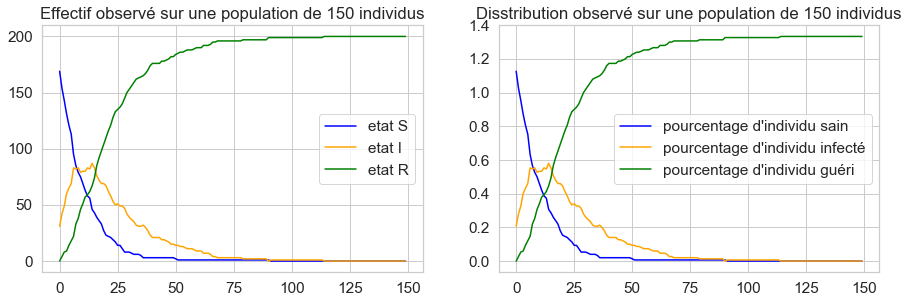

In [65]:
T = 150
Effectif = 200
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

affiche_repartition_sir(T, Effectif, pi_0, A)

À partir des graphes simulés ci-dessous, on peut observer que plus $t$ est grand, plus la proportion d'individus sains et infectés s'approchent de $0$, et en revanche, plus la proportion d'individus guéris se converge vers $1$.

##### b. Évolution d'une population de 5 individus

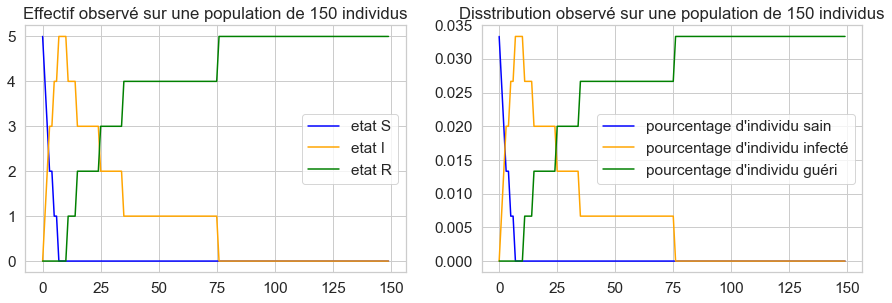

In [66]:
T = 150
Effectif = 5
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

affiche_repartition_sir(T, Effectif, pi_0, A)

##### c. Évolution d'une population de 5000 individus

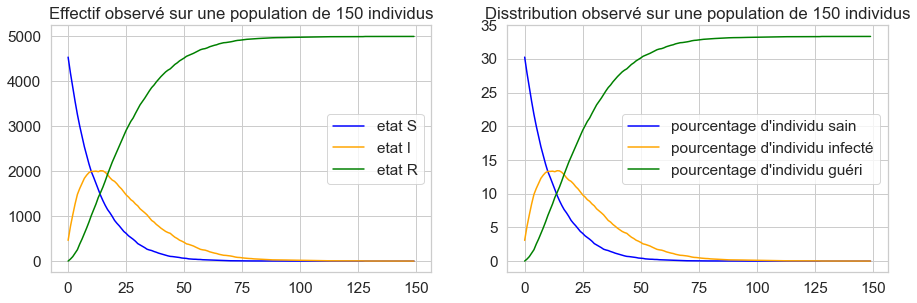

In [67]:
T = 150
Effectif = 5000
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

affiche_repartition_sir(T, Effectif, pi_0, A)

##### d. Évolution d'une population de 50000 individus

In [68]:
T = 150
Effectif = 50000
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

affiche_repartition_sir(T, Effectif, pi_0, A)